# Luther - Linear Regression Model

This is where I work with the merged dataframe to fit a linear regression model in order to predict the opening box office gross

In [74]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from scipy.stats import boxcox
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
% matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import warnings
warnings.filterwarnings('ignore')

In [75]:
# Import merged dataframe
merged_df = pd.read_pickle('data/merged_df.pkl')
test_2018 = pd.read_pickle('data/merged_2018.pkl')
merged_df.head(7)

,movie_name,movie,op_gross,est_tick,date_time,theaters,tot_gross,unemp_rate,imdb,metacritic,...,year,Yviews_adj,Ylikes_adj,Ydis_adj,Ycom_adj,tick,act_gross,act_nmovies,dir_gross,dir_nmovies
0,The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,158074286,19443331,2013-11-22,4163,424668047,6.900,7.500,76,...,2013,5649515.000,23726.000,632.000,4329.000,8.130,3333.400,56,1056.500,7
1,Frozen,Frozen,243390,29937,2013-11-22,1,400738009,6.900,7.500,74,...,2013,4249150.000,6715.000,1074.000,925.000,8.130,1774.200,19,230.000,3
2,Thor: The Dark World,Thor: The Dark World,85737841,10545859,2013-11-08,3841,206362140,6.900,7.000,54,...,2013,8467428.000,30885.000,1178.000,5576.000,8.130,2968.600,57,89.700,2
3,The Best Man Holiday,The Best Man Holiday,30107555,3703266,2013-11-15,2024,70525195,6.900,6.700,59,...,2013,454111.000,1194.000,72.000,172.000,8.130,1328.500,34,346.300,9
4,Last Vegas,Last Vegas,16334566,2009171,2013-11-01,3065,63914167,6.900,6.600,48,...,2013,382762.000,514.000,44.000,47.000,8.130,4458.300,81,843.500,10
5,Ender's Game,Ender's Game,27017351,3323167,2013-11-01,3407,61737191,6.900,6.700,51,...,2013,1673684.000,4379.000,288.000,1414.000,8.130,4902.100,52,0.000,0
6,Free Birds,Free Birds,15805237,1944063,2013-11-01,3736,55750480,6.900,5.900,38,...,2013,386277.000,945.000,77.000,130.000,8.130,2996.100,56,165.000,3


In [76]:
# add these columns to account for whether the actors/directors were identified
merged_df["dirgross_bin"] = merged_df.dir_gross.apply(lambda x: x/x if x > 0 else x)
merged_df["actgross_bin"] = merged_df.act_gross.apply(lambda x: x/x if x > 0 else x)
test_2018["dirgross_bin"] = merged_df.dir_gross.apply(lambda x: x/x if x > 0 else x)
test_2018["actgross_bin"] = merged_df.act_gross.apply(lambda x: x/x if x > 0 else x)
merged_df.head()

,movie_name,movie,op_gross,est_tick,date_time,theaters,tot_gross,unemp_rate,imdb,metacritic,...,Ylikes_adj,Ydis_adj,Ycom_adj,tick,act_gross,act_nmovies,dir_gross,dir_nmovies,dirgross_bin,actgross_bin
0,The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,158074286,19443331,2013-11-22,4163,424668047,6.900,7.500,76,...,23726.000,632.000,4329.000,8.130,3333.400,56,1056.500,7,1.000,1.000
1,Frozen,Frozen,243390,29937,2013-11-22,1,400738009,6.900,7.500,74,...,6715.000,1074.000,925.000,8.130,1774.200,19,230.000,3,1.000,1.000
2,Thor: The Dark World,Thor: The Dark World,85737841,10545859,2013-11-08,3841,206362140,6.900,7.000,54,...,30885.000,1178.000,5576.000,8.130,2968.600,57,89.700,2,1.000,1.000
3,The Best Man Holiday,The Best Man Holiday,30107555,3703266,2013-11-15,2024,70525195,6.900,6.700,59,...,1194.000,72.000,172.000,8.130,1328.500,34,346.300,9,1.000,1.000
4,Last Vegas,Last Vegas,16334566,2009171,2013-11-01,3065,63914167,6.900,6.600,48,...,514.000,44.000,47.000,8.130,4458.300,81,843.500,10,1.000,1.000


In [77]:
# Test on entire 2013-2017 dataset
merged_test = test_2018
merged_train = merged_df

In [78]:
merged_test.columns

Index(['movie_name', 'movie', 'op_gross', 'est_tick', 'date_time', 'theaters',
       'tot_gross', 'unemp_rate', 'imdb', 'metacritic', 'rated',
       'rotten_tomatoes', 'runtime', 'year', 'Yviews_adj', 'Ylikes_adj',
       'Ydis_adj', 'Ycom_adj', 'tick', 'act_gross', 'act_nmovies', 'dir_gross',
       'dir_nmovies', 'dirgross_bin', 'actgross_bin'],
      dtype='object')

In [79]:
#merged2.columns
#drop unnecessary/duplicate columns
merged_test = merged_test.drop(["movie","movie_name","tick", "year",
                        "tot_gross","op_gross","date_time"],1)
merged_train = merged_train.drop(["movie","movie_name","tick", "year",
                        "tot_gross","op_gross","date_time"],1)


In [80]:
X_train = patsy.dmatrix('rated',data=merged_train,return_type='dataframe')
X_test = patsy.dmatrix('rated',data=merged_test,return_type='dataframe')
X_train.head()

,Intercept,rated[T.PG],rated[T.PG-13],rated[T.R]
0,1.000,0.000,1.000,0.000
1,1.000,1.000,0.000,0.000
2,1.000,0.000,1.000,0.000
3,1.000,0.000,0.000,1.000
4,1.000,0.000,1.000,0.000


In [81]:
merged2_test = merged_test.join(X_test)
merged2_test = merged_test.drop(["rated"],1)
merged2_train = merged_train.join(X_train)
merged2_train = merged_train.drop(["rated"],1)


In [82]:
#sns.pairplot(merged2)
#sns.regplot(merged2.unemp_rate, merged2.est_tick)
# Add 1 to the comments, director gross and actor gross in order to normalize data with 
# log or boxcox
merged2_test['Ycom_adj'] = merged2_test.Ycom_adj.apply(lambda x: x + 1)
merged2_test['dir_gross'] = merged2_test.dir_gross.apply(lambda x: x + 1)
merged2_test['act_gross'] = merged2_test.act_gross.apply(lambda x: x + 1)
merged2_test['act_nmovies'] = merged2_test.act_gross.apply(lambda x: x + 1)
merged2_test['dir_nmovies'] = merged2_test.act_gross.apply(lambda x: x + 1)

merged2_train['Ycom_adj'] = merged2_train.Ycom_adj.apply(lambda x: x + 1)
merged2_train['dir_gross'] = merged2_train.dir_gross.apply(lambda x: x + 1)
merged2_train['act_gross'] = merged2_train.act_gross.apply(lambda x: x + 1)
merged2_train['act_nmovies'] = merged2_train.act_gross.apply(lambda x: x + 1)
merged2_train['dir_nmovies'] = merged2_train.act_gross.apply(lambda x: x + 1)

In [83]:
# Normalize dataset with log transformation
merged2_train["tick_log"] = np.log(merged2_train.est_tick)
merged2_train["Ylikes_log"] = np.log(merged2_train.Ylikes_adj)
merged2_train["Yviews_log"] = np.log(merged2_train.Yviews_adj)
merged2_train["Ydis_log"] = np.log(merged2_train.Ydis_adj)
merged2_train["runtime_log"] = np.log(merged2_train.runtime)
merged2_train["dir_gross"] = np.log(merged2_train.dir_gross)
merged2_train["act_gross"] = np.log(merged2_train.act_gross)
merged2_train["Ycom_log"] = np.log(merged2_train.Ycom_adj)
merged3_train = merged2_train.drop(["est_tick","Ylikes_adj","Yviews_adj","Ydis_adj","runtime",
                       "act_gross","dir_gross","Ycom_adj"], 1)

merged2_test["tick_log"] = np.log(merged2_test.est_tick)
merged2_test["Ylikes_log"] = np.log(merged2_test.Ylikes_adj)
merged2_test["Yviews_log"] = np.log(merged2_test.Yviews_adj)
merged2_test["Ydis_log"] = np.log(merged2_test.Ydis_adj)
merged2_test["runtime_log"] = np.log(merged2_test.runtime)
merged2_test["dir_gross"] = np.log(merged2_test.dir_gross)
merged2_test["act_gross"] = np.log(merged2_test.act_gross)
merged2_test["Ycom_log"] = np.log(merged2_test.Ycom_adj)
merged3_test = merged2_test.drop(["est_tick","Ylikes_adj","Yviews_adj","Ydis_adj","runtime",
                       "act_gross","dir_gross","Ycom_adj"], 1)

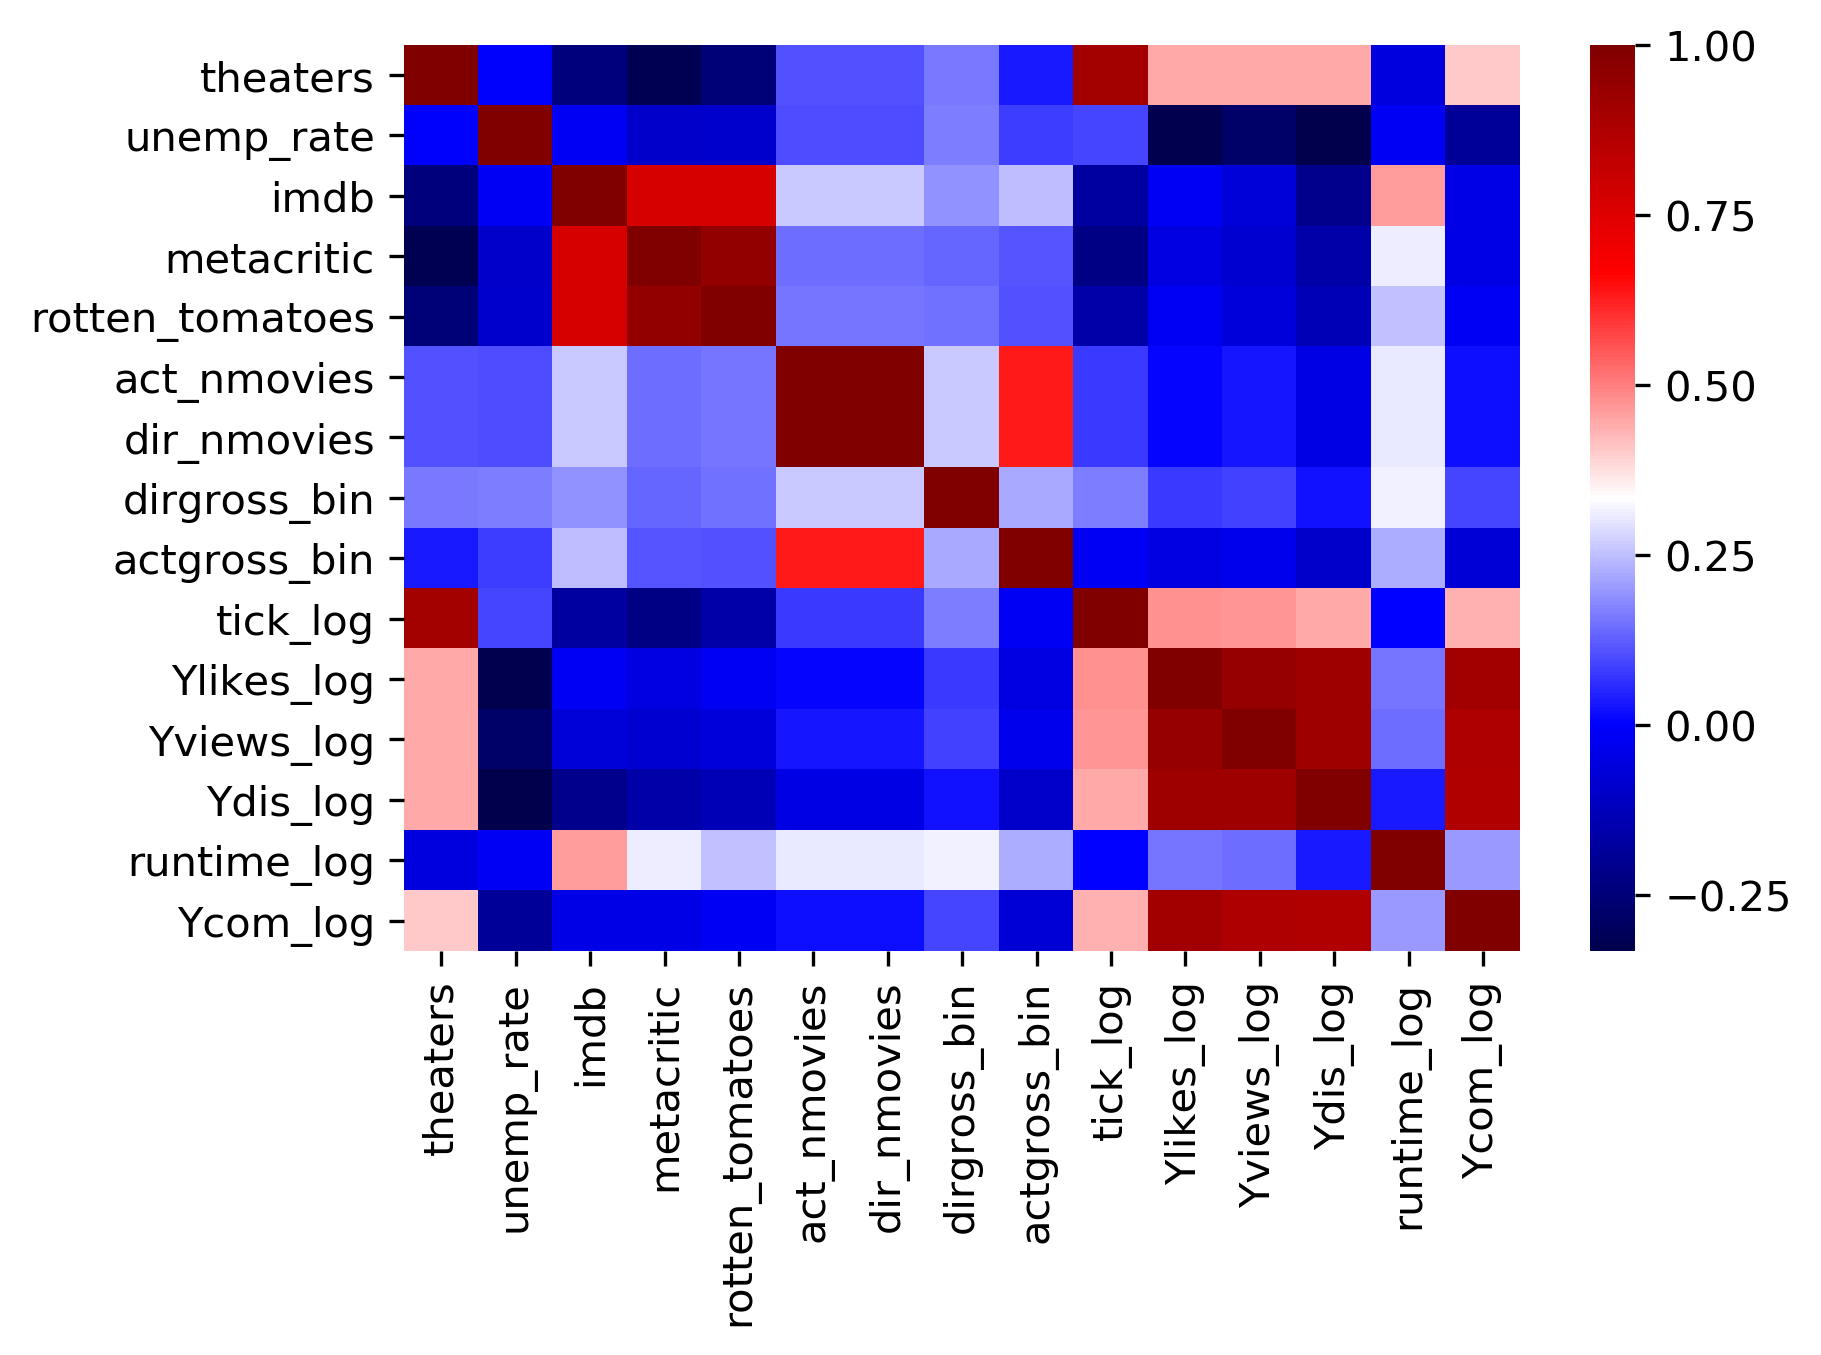

In [84]:
sns.heatmap(merged3_train.corr(), cmap = "seismic")

In [85]:
merged3_train.columns

Index(['theaters', 'unemp_rate', 'imdb', 'metacritic', 'rotten_tomatoes',
       'act_nmovies', 'dir_nmovies', 'dirgross_bin', 'actgross_bin',
       'tick_log', 'Ylikes_log', 'Yviews_log', 'Ydis_log', 'runtime_log',
       'Ycom_log'],
      dtype='object')

In [86]:
y_train = merged3_train.tick_log
X_train = merged3_train.drop(['tick_log'],1)

y_test = merged3_test.tick_log
X_test = merged3_test.drop(['tick_log'],1)
#model= LinearRegression()
#fit = model.fit(X,y)

In [87]:
# Split train test set
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
# The Xtrain and Ytrain will be used to train the data & cross validate
# X test and Y test will be used to assess the performance after CV

In [88]:
#Split CV
X_trainCV, X_CV, y_trainCV, y_CV = train_test_split(X_train,y_train,test_size = 0.3,
                                                   random_state= 32)

In [89]:
# alphas = [0,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
# elas_model = ElasticNetCV(alphas=alphas, l1_ratio=[1e-8, 1e-6, 1e-4, 1e-2, .5, 1])
# fit = elas_model.fit(X_train,y_train)
# #fit.predict(X_train)
# fit.alpha_
# fit.l1_ratio_

In [90]:
# Linear model without polyfit
alphas = [0,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
l1 = [0, 1e-8, 1e-6, 1e-4, 1e-2, .5, .9, 1]
degree = 2
lin_model = make_pipeline(ElasticNetCV(alphas=alphas, l1_ratio = l1,cv=10))
lin_model.fit(X_trainCV,y_trainCV)
print("alpha =", lin_model.named_steps.elasticnetcv.alpha_)
print("l1_ratio =", lin_model.named_steps.elasticnetcv.l1_ratio_)
print("R^2 on CV =", lin_model.score(X_CV,y_CV))

alpha = 0.1
l1_ratio = 0.0
R^2 on CV = 0.8520581798087383


In [91]:
# Polyfit model
alphas = [1e-4,1e-3,1e-2,1e-1,1,10,30,60,90,100,300,600]
l1 = [0, .1, .5, .7, .9, .95, .99, 1]
degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree),
                    ElasticNetCV(alphas=alphas, l1_ratio = l1,cv=10))
poly_model.fit(X_trainCV,y_trainCV)
print("alpha =", poly_model.named_steps.elasticnetcv.alpha_)
print("l1_ratio =", poly_model.named_steps.elasticnetcv.l1_ratio_)
print("R^2 on CV =", poly_model.score(X_CV,y_CV))

alpha = 100.0
l1_ratio = 0.7
R^2 on CV = 0.883855105538375


In [92]:
# Polyfit model
alphas = [1e-4,1e-3,1e-2,1e-1,1,10,30,60,90,100,300,600]
l1 = [0, .1, .5, .7, .9, .95, .99, 1]
degree = 2
poly_model_lasso = make_pipeline(PolynomialFeatures(degree),
                    LassoCV(alphas=alphas,cv=10))
poly_model_lasso.fit(X_trainCV,y_trainCV)
print("alpha =", poly_model_lasso.named_steps.lassocv.alpha_)
#print("l1_ratio =", poly_model_lasso.named_steps.elasticnetcv.l1_ratio_)
print("R^2 on CV =", poly_model_lasso.score(X_CV,y_CV))

alpha = 60.0
R^2 on CV = 0.8840893070361946


In [93]:
import math
from sklearn.metrics import mean_squared_error
rms = math.exp(math.sqrt(mean_squared_error(y_test, poly_model.predict(X_test))))
r_squared = poly_model.score(X_test,y_test)
print("R^2 =", r_squared)
print("rms =", rms)

#poly_model.predict(X_CV)

R^2 = -19.507955034314516
rms = 1.735607661847123


In [94]:
def diagnostic_plot(x, y, model):
    plt.figure(figsize=(20,5))
    
    rgr = model
    model.fit(x,y)
    pred = model.predict(x)

#     plt.subplot(1, 3, 1)
#     plt.scatter(x,y)
#     plt.plot(x, pred, color='blue',linewidth=1)
#     plt.title("Regression fit")
#     plt.xlabel("x")
#     plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    

NameError: name 'stats' is not defined

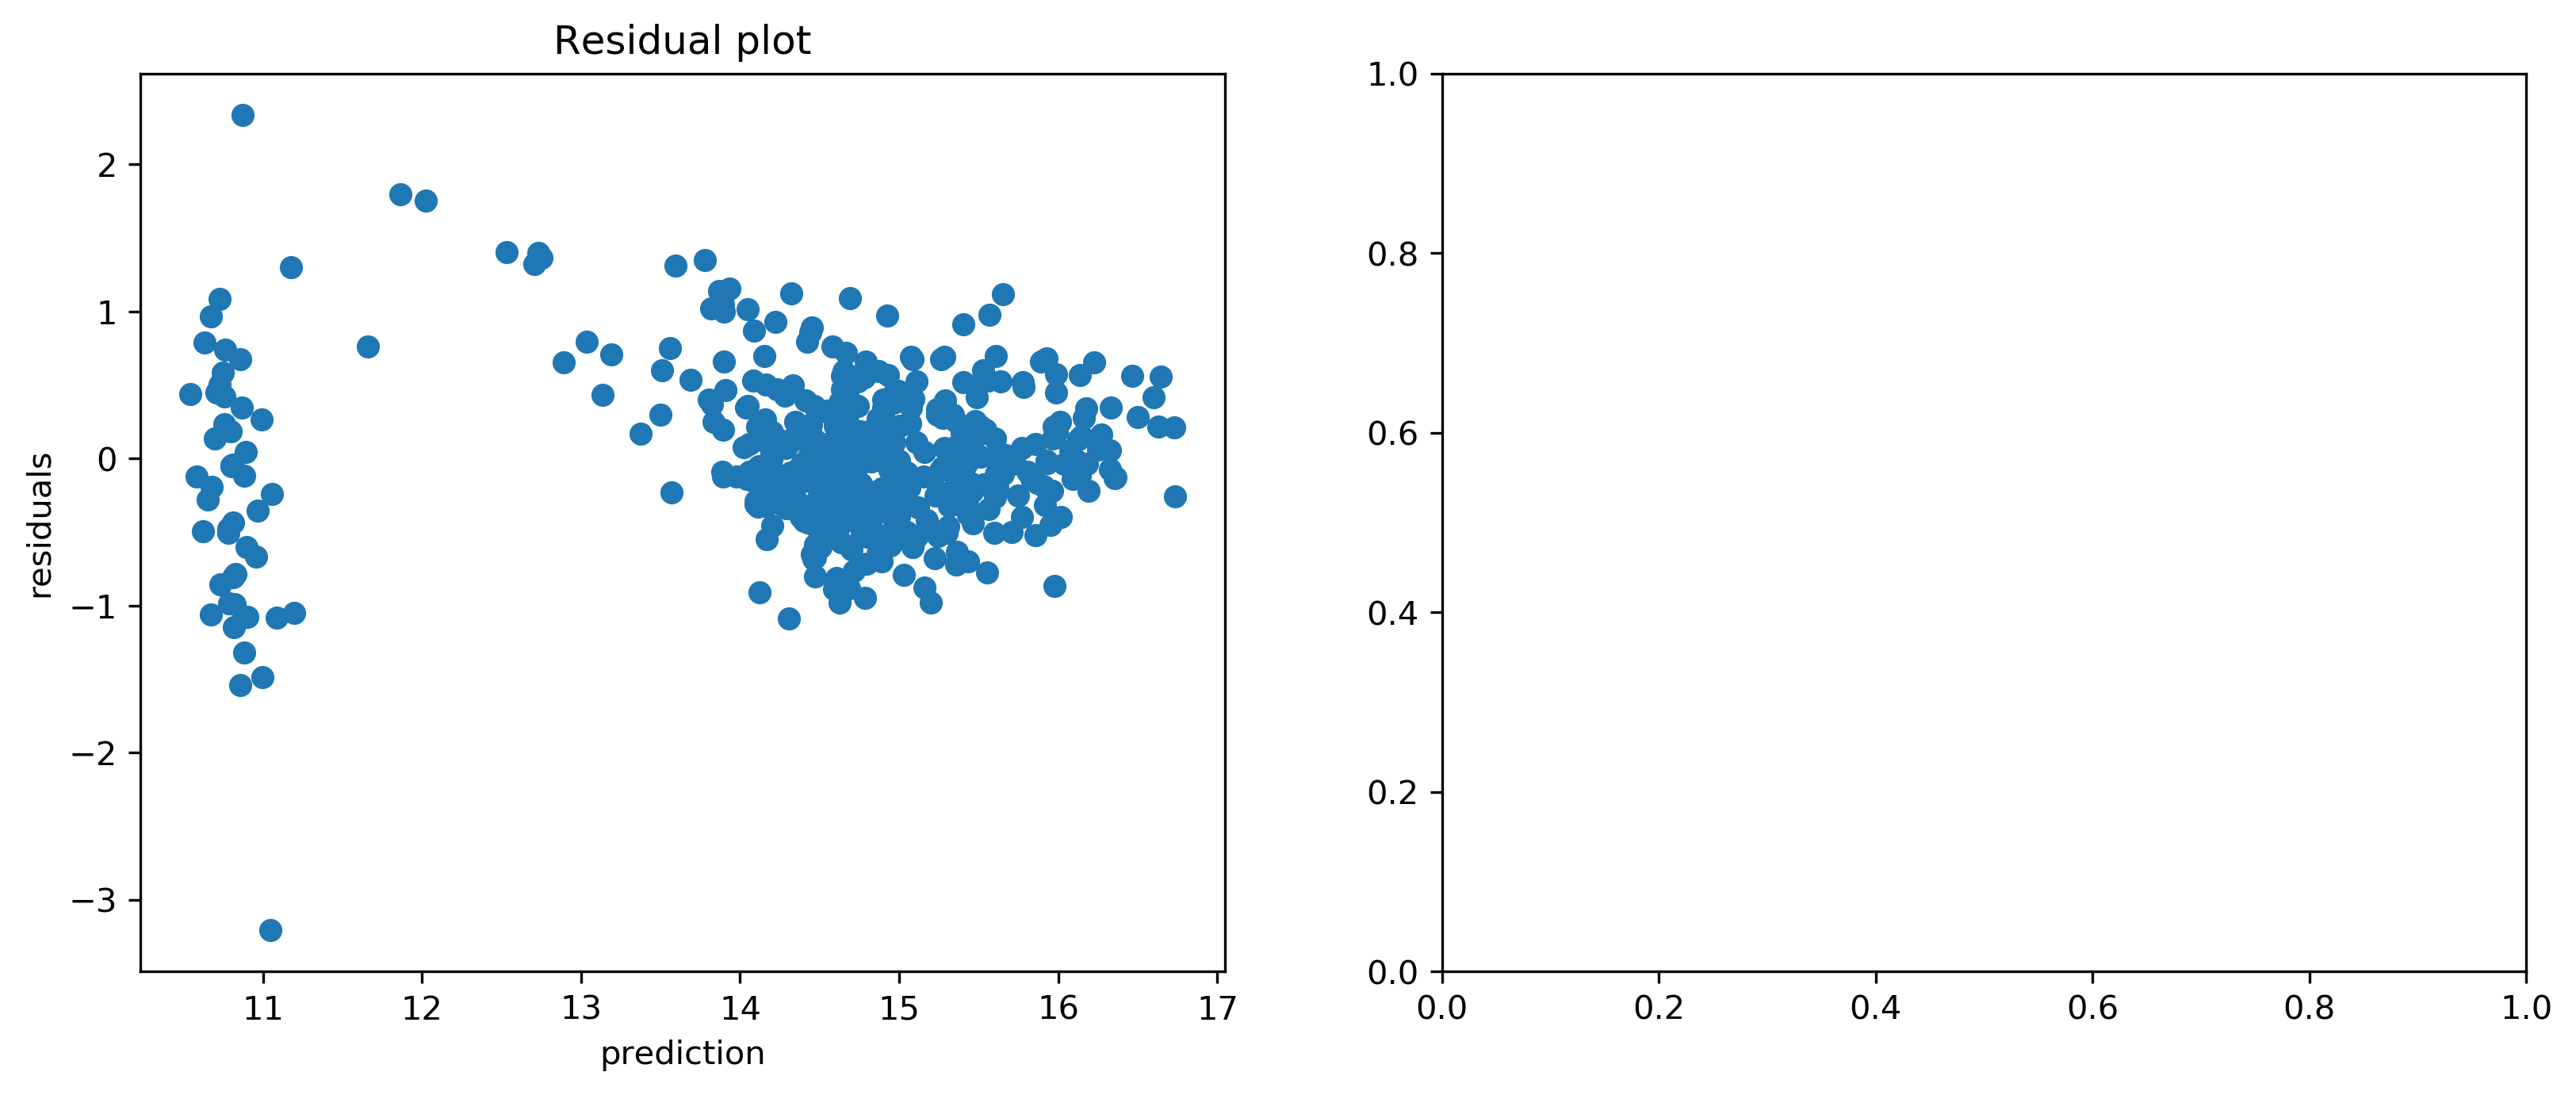

In [95]:
diagnostic_plot(X_train, y_train, poly_model)

In [ ]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis
merged4 = merged3_train
merged4['predict']=poly_model.predict(X_train)
merged4['resid']=merged3_train.tick_log-merged4_train.predict
with sns.axes_style('white'):
    plot=merged4.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))


## See how well the linear regression performs on 2017 data

In [96]:
prediction = poly_model.predict(X_test)

In [97]:
math.exp(16.854)

20873688.492063176

In [98]:
test_2018 = test_2018.drop(["movie","date_time","theaters","unemp_rate",
                                 "imdb","metacritic","Ycom_adj","Ylikes_adj",
                                 "Ydis_adj","rotten_tomatoes","runtime",
                                 "dir_nmovies","dirgross_bin","actgross_bin",
                                 "dir_gross","act_gross","act_nmovies"],1)
test_2018["predict_tick"] = prediction
test_2018["predict_tick"] = test_2018.predict_tick.apply(lambda x: math.exp(x))
test_2018["predict_gross"] = test_2018.predict_tick.multiply(test_2018.tick)
test_2018["predict_gross_error"] = test_2018.op_gross.subtract(test_2018.predict_gross)
test_2018["predict_tick_error"] = test_2018.est_tick.subtract(test_2018.predict_tick)
test_2018["percent_gross_error"] = test_2018.predict_gross_error.divide(
    test_2018.op_gross)
test_2018["percent_gross_error"] = test_2018.percent_gross_error.apply(lambda x: abs(x))
test_2018.head()

,movie_name,op_gross,est_tick,tot_gross,rated,year,Yviews_adj,tick,predict_tick,predict_gross,predict_gross_error,predict_tick_error,percent_gross_error
0,Black Panther,202003951,22052833,689626132,PG-13,2018,16925992.000,9.160,10460561.239,95818740.952,106185210.048,11592271.761,0.526
1,Avengers: Infinity War,257698183,28132989,322831270,PG-13,2018,67293118.000,9.160,19901133.698,182294384.670,75403798.330,8231855.302,0.293


In [99]:
test_2018.percent_gross_error.describe()

count   2.000
mean    0.409
std     0.165
min     0.293
25%     0.351
50%     0.409
75%     0.467
max     0.526
Name: percent_gross_error, dtype: float64

0.250   83099151.260
0.500   90794504.189
0.750   98489857.119
Name: predict_gross_error, dtype: float64


(array([ 70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110.]),
 <a list of 9 Text xticklabel objects>)

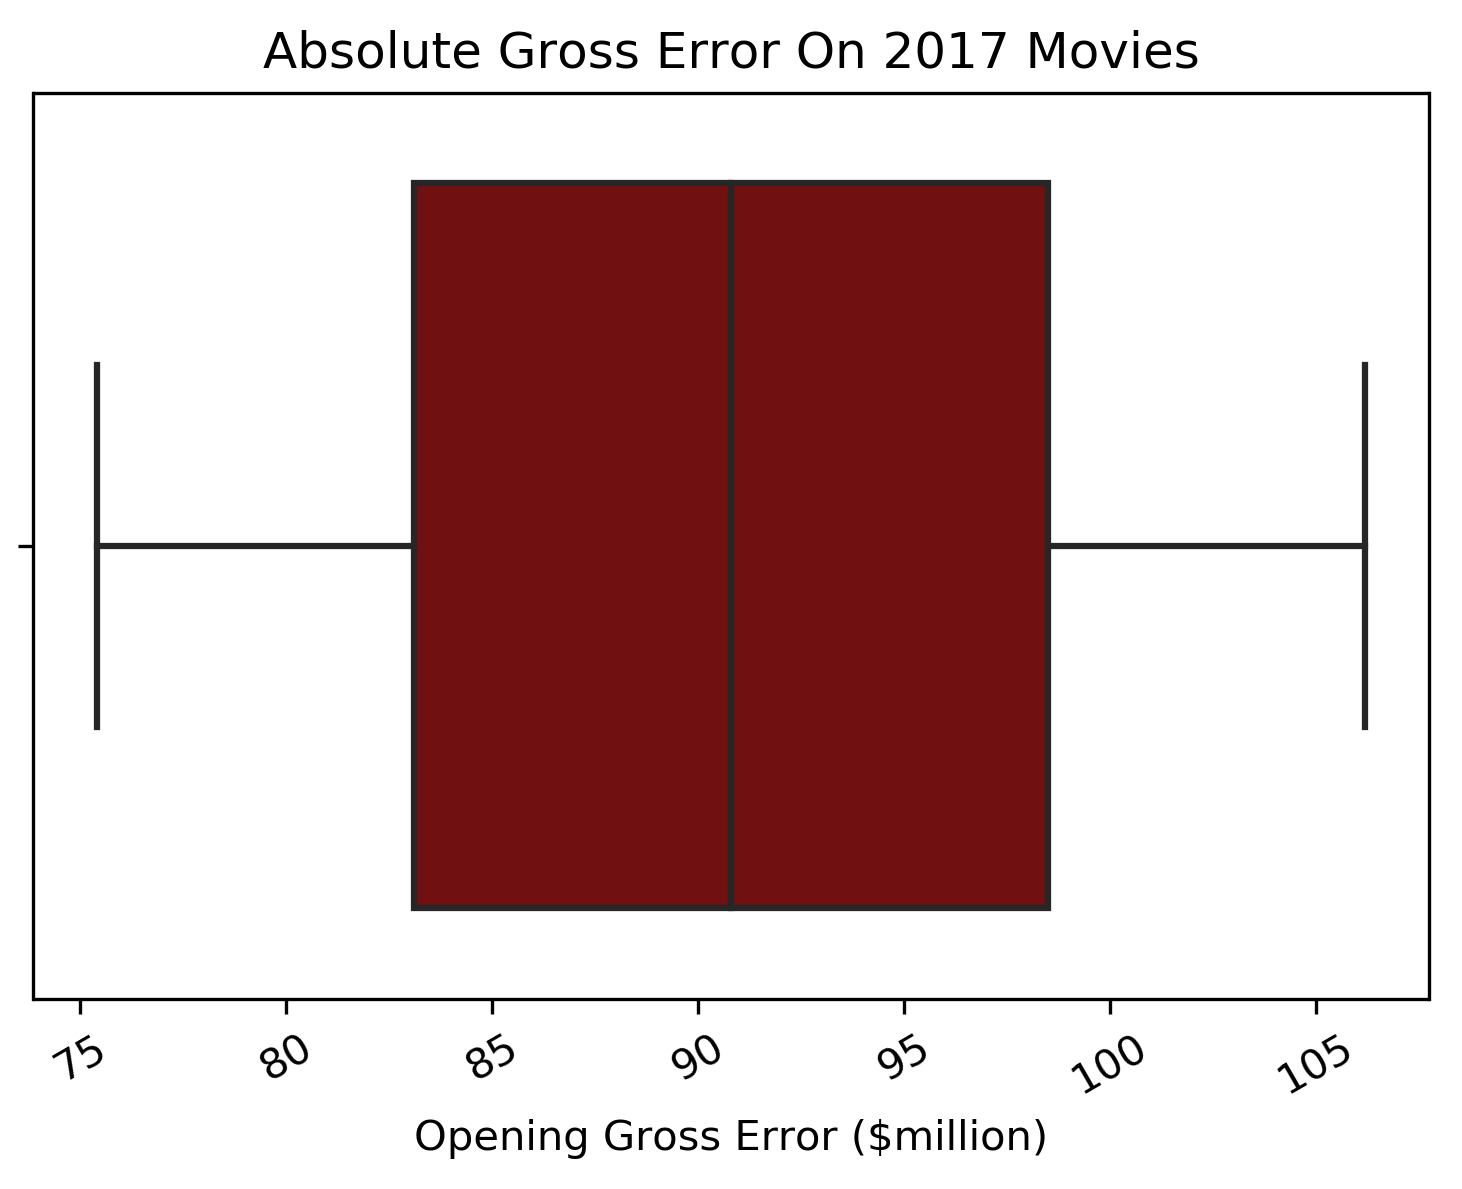

In [100]:
print(test_2018.predict_gross_error.quantile([0.25,0.5,0.75]))
sns.boxplot(test_2018.predict_gross_error.apply(lambda x: x/1e6),color="maroon")
#plt.xlim(0, None)
plt.xlabel("Opening Gross Error ($million)")
#plt.xlabel("Actual Gross ($million)")
plt.title("Absolute Gross Error On 2017 Movies")
#plt.ticklabel_format(style='plain')
plt.xticks(rotation=30)

0.250   0.351
0.500   0.409
0.750   0.467
Name: percent_gross_error, dtype: float64


(array([  0., 100., 200., 300., 400., 500.]),
 <a list of 6 Text xticklabel objects>)

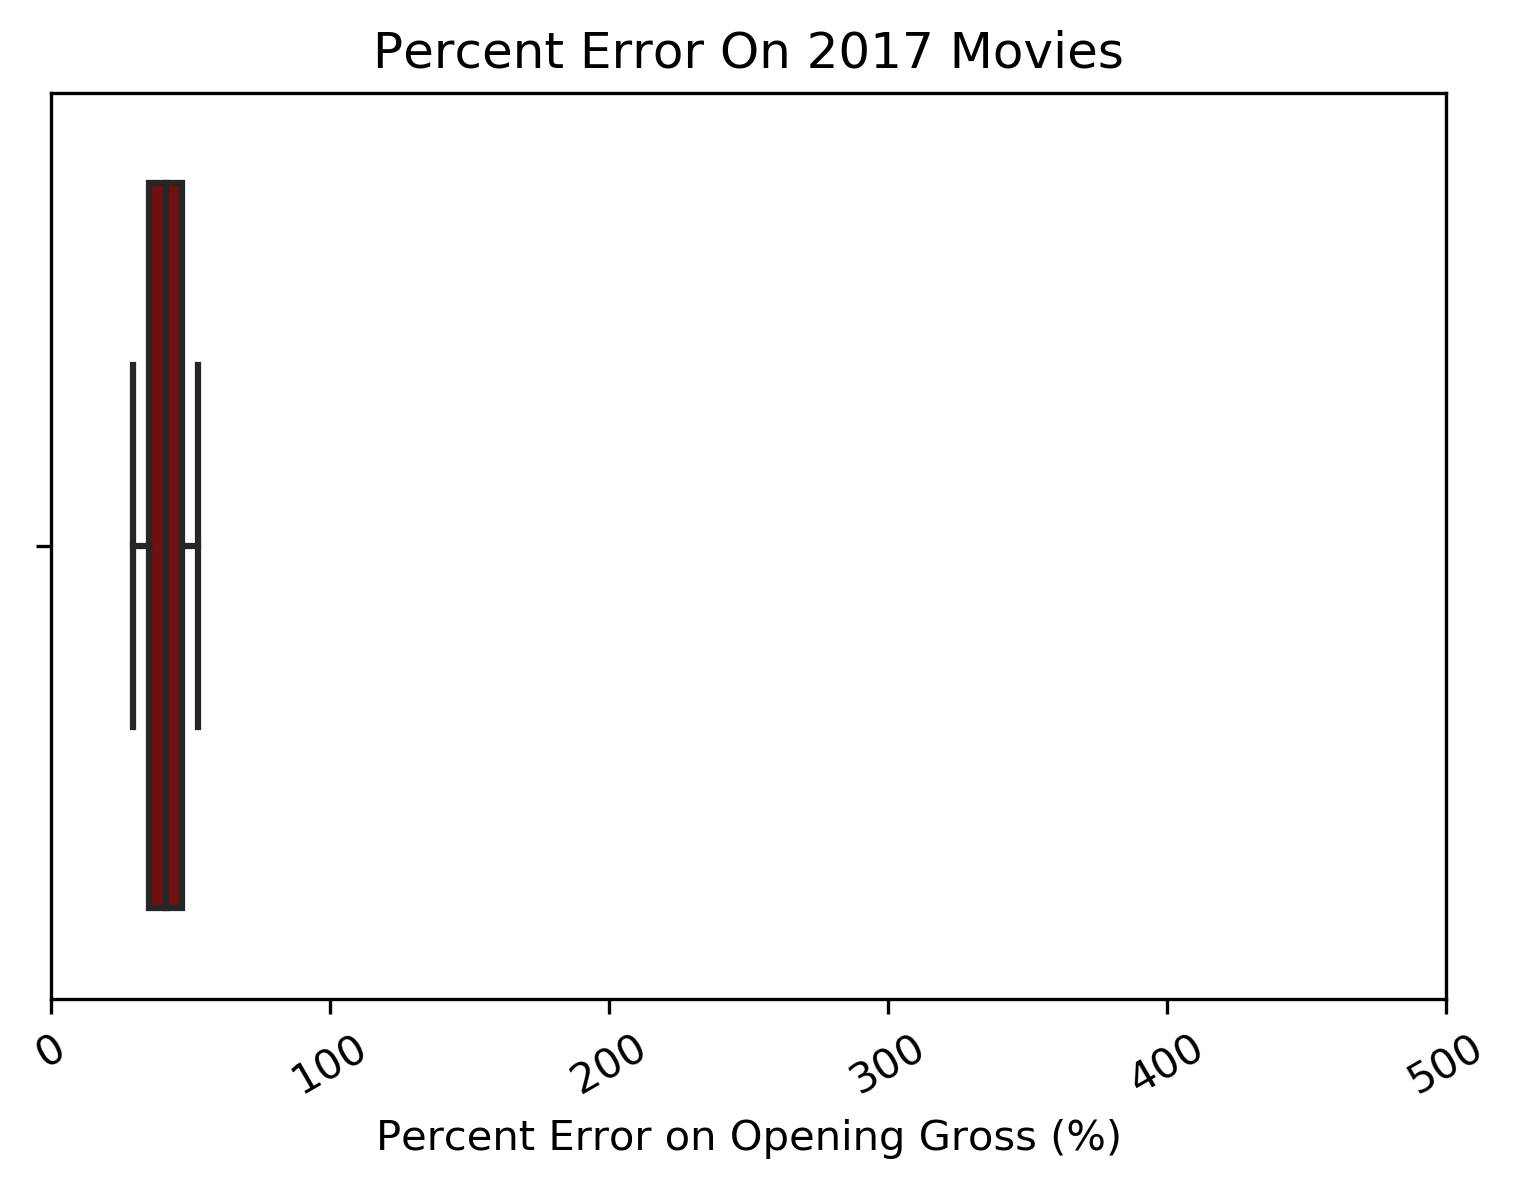

In [101]:
print(test_2018.percent_gross_error.quantile([0.25,0.5,0.75]))
sns.boxplot(test_2018.percent_gross_error*100,color="maroon")
plt.xlim(0, 500)
plt.xlabel("Percent Error on Opening Gross (%)")
plt.title("Percent Error On 2017 Movies")
plt.xticks(rotation=30)

(array([190., 200., 210., 220., 230., 240., 250., 260., 270.]),
 <a list of 9 Text xticklabel objects>)

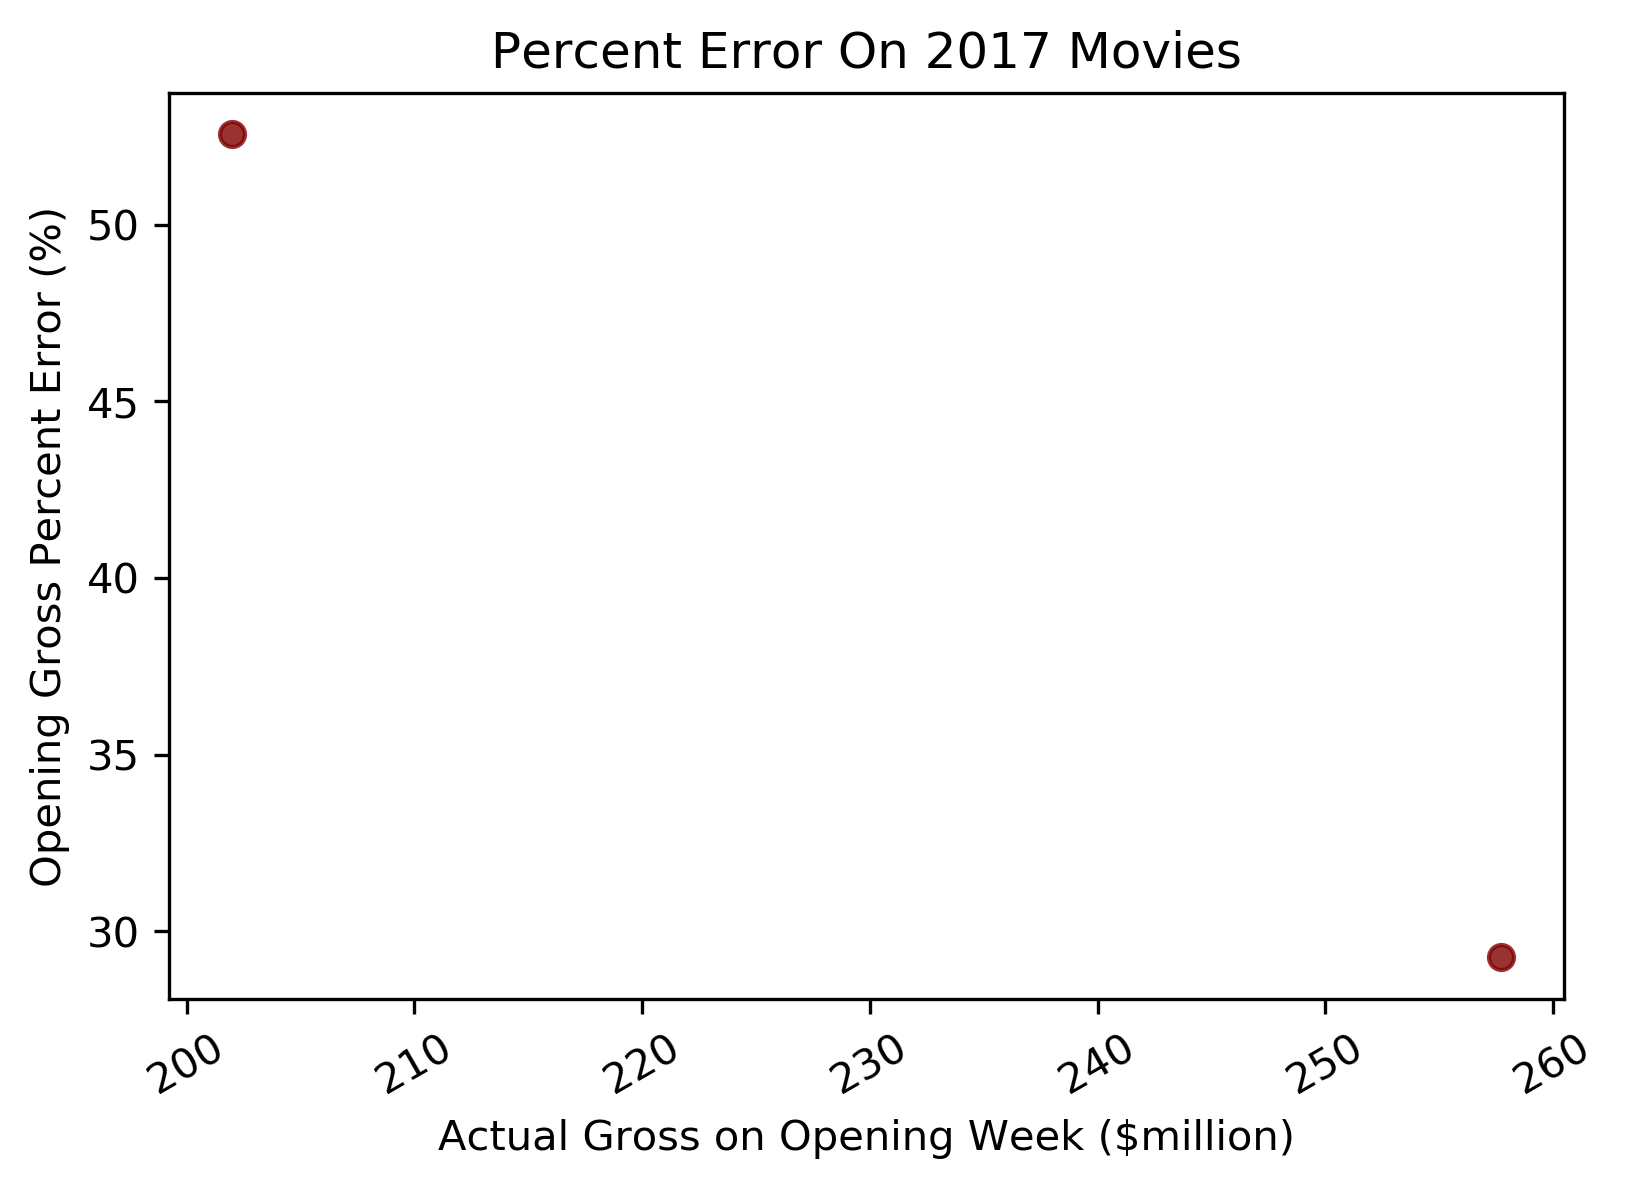

In [102]:
import matplotlib.pyplot as plt
sns.regplot(test_2018.op_gross/1e6, test_2018.percent_gross_error*100,fit_reg=False,
           color="maroon")
# plt.ylim(0, 500)
# plt.xlim(0, None)
plt.ylabel("Opening Gross Percent Error (%)")
plt.xlabel("Actual Gross on Opening Week ($million)")
plt.title("Percent Error On 2017 Movies")
plt.ticklabel_format(style='plain')
plt.xticks(rotation=30)

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 7 Text xticklabel objects>)

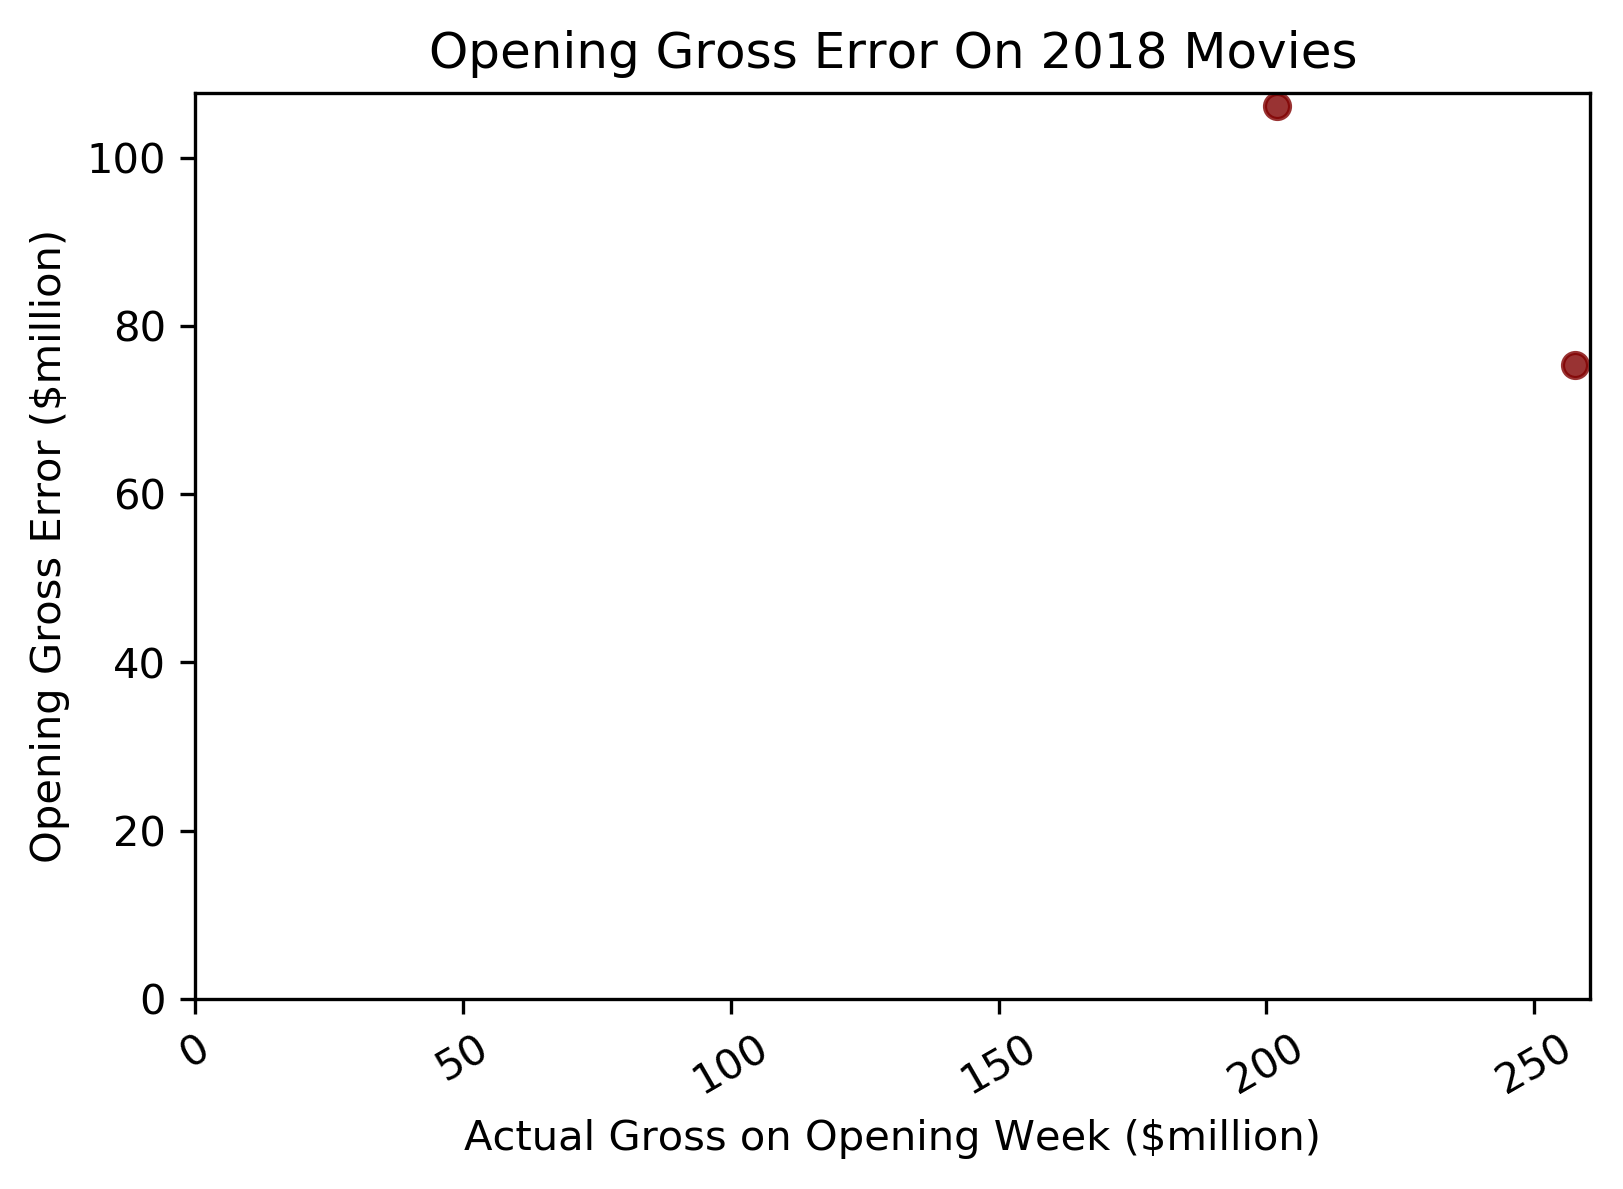

In [103]:
import matplotlib.pyplot as plt
sns.regplot(test_2018.op_gross/1e6, test_2018.predict_gross_error/1e6,fit_reg=False,
            color="maroon")
plt.ylim(0, None)
plt.xlim(0, None)
plt.ylabel("Opening Gross Error ($million)")
plt.xlabel("Actual Gross on Opening Week ($million)")
plt.title("Opening Gross Error On 2018 Movies")
plt.ticklabel_format(style='plain')
plt.xticks(rotation=30)

In [104]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
test_2018.sort_values(by="percent_gross_error",ascending=False).head()

,movie_name,op_gross,est_tick,tot_gross,rated,year,Yviews_adj,tick,predict_tick,predict_gross,predict_gross_error,predict_tick_error,percent_gross_error
0,Black Panther,202003951,22052833,689626132,PG-13,2018,16925992.000,9.160,10460561.239,95818740.952,106185210.048,11592271.761,0.526
1,Avengers: Infinity War,257698183,28132989,322831270,PG-13,2018,67293118.000,9.160,19901133.698,182294384.670,75403798.330,8231855.302,0.293


In [105]:
test_2018.iloc[1,:]

movie_name             Avengers: Infinity War
op_gross                            257698183
est_tick                             28132989
tot_gross                           322831270
rated                                   PG-13
year                                     2018
Yviews_adj                       67293118.000
tick                                    9.160
predict_tick                     19901133.698
predict_gross                   182294384.670
predict_gross_error              75403798.330
predict_tick_error                8231855.302
percent_gross_error                     0.293
Name: 1, dtype: object

In [746]:
# Check the coefficients for the features in the final model
poly_coeff = pd.DataFrame({"feature" : poly_model.named_steps.polynomialfeatures.get_feature_names(),
              "coefficients" : poly_model.named_steps.elasticnetcv.coef_})
poly_coeff.sort_values(by="coefficients",ascending=False).head(7)
#merged2.iloc[393,:]

,coefficients,feature
68,0.004,x4 x7
62,0.004,x3 x11
44,0.003,x2 x4
31,0.003,x1 x3
61,0.002,x3 x10
73,0.002,x4 x12
74,0.002,x4 x13


In [ ]:
# # Statsmodel
# model = sm.OLS(y,X)
# # Fit your model to your training set
# fit = model.fit()
# # Print summary statistics of the model's performance
# fit.summary()